In [1]:
import pandas as pd
import sweetviz as svz

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
assessments = pd.read_csv('assessments.csv') # информациz об оценках в тесте
courses = pd.read_csv('courses.csv') # список предметов по семестрам
student_assessment = pd.read_csv('studentAssessment.csv') # результаты тестов студентов
student_registration = pd.read_csv('studentRegistration.csv') # информаця о регистрации для прохождения курса

# Начнём с EDA
Для этого использую библиотеку sweetviz

In [6]:
assessments_report = svz.analyze(assessments)
courses_report = svz.analyze(courses)
student_assessment_report = svz.analyze(student_assessment)
student_registration_report = svz.analyze(student_registration)

                                             |                                             | [  0%]   00:00 ->…

                                             |                                             | [  0%]   00:00 ->…

                                             |                                             | [  0%]   00:00 ->…

                                             |                                             | [  0%]   00:00 ->…


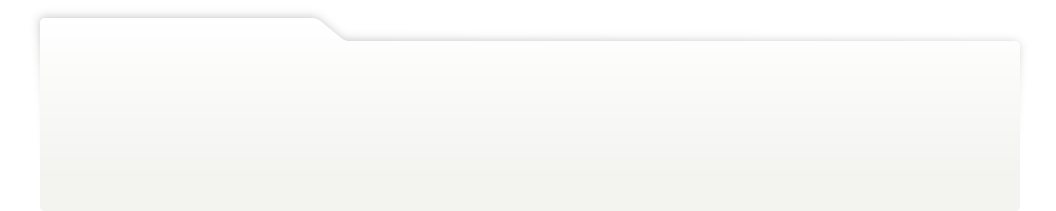
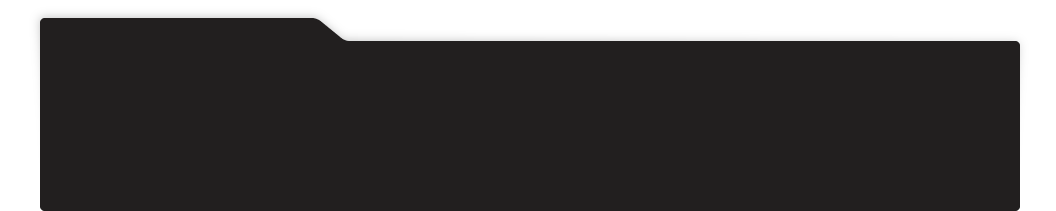
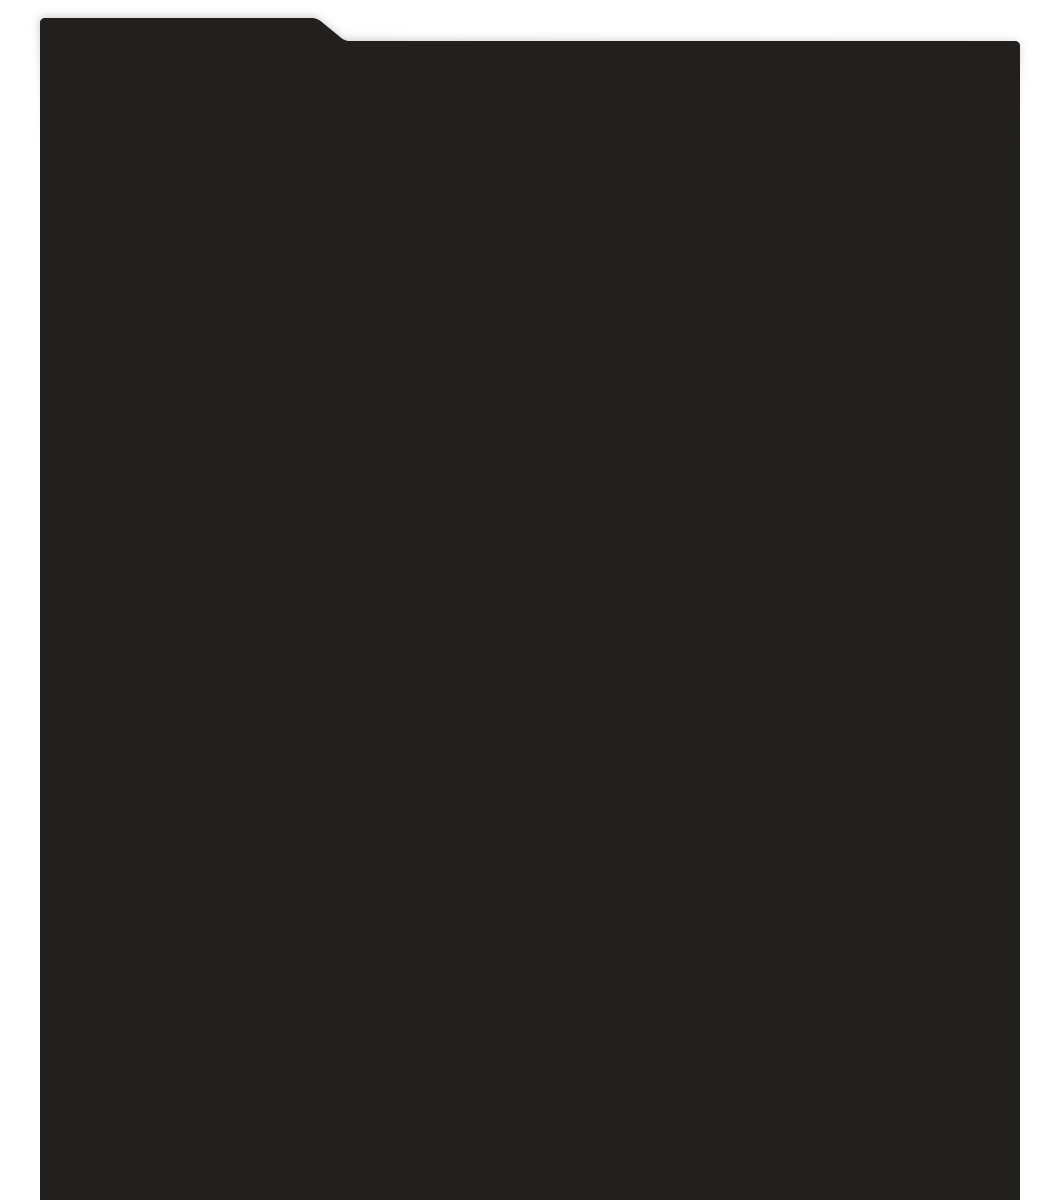
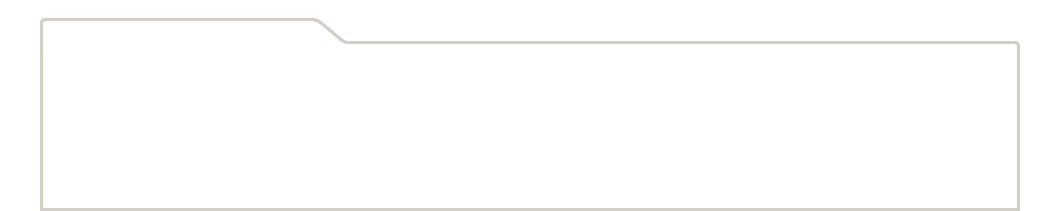
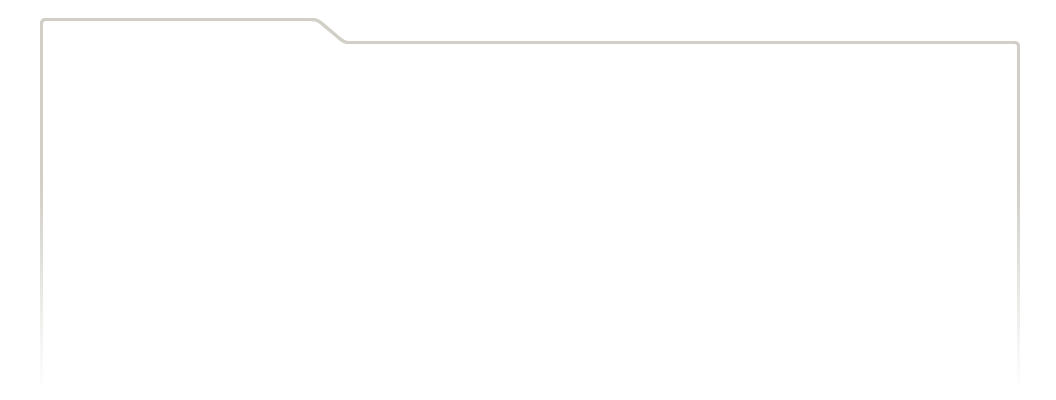
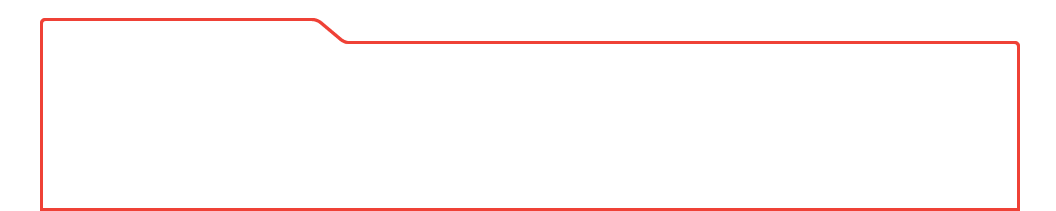
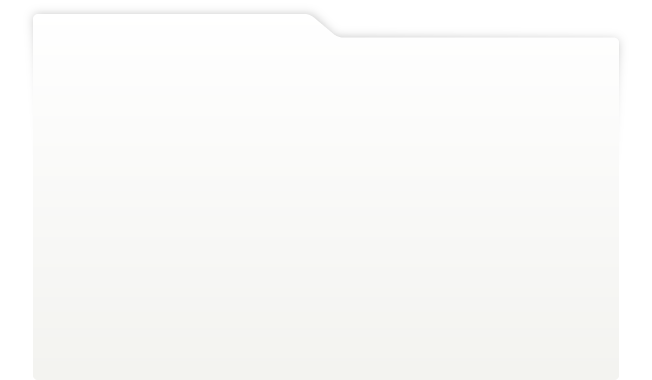
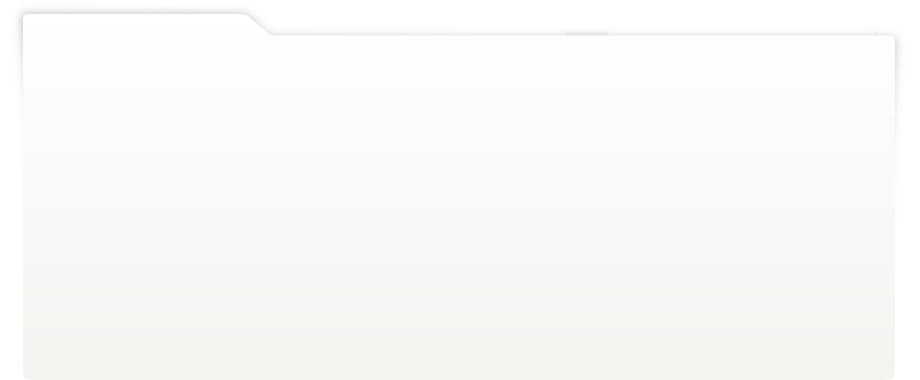
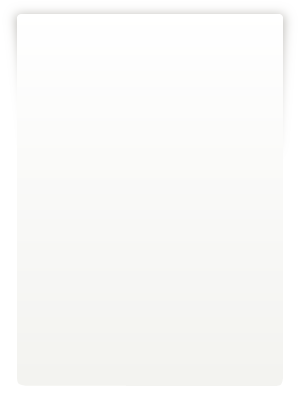
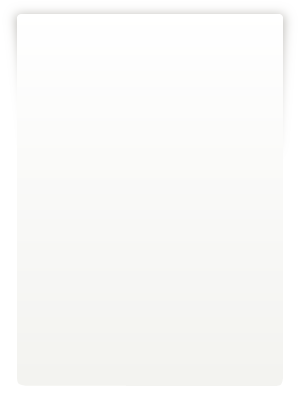
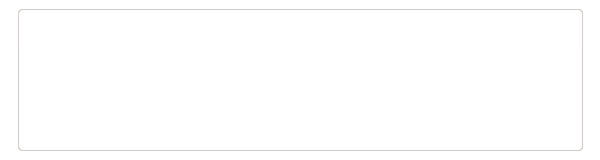
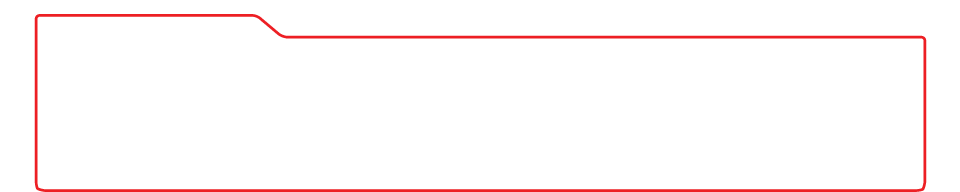
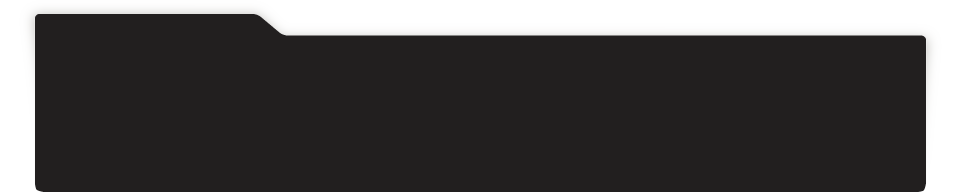
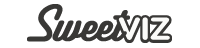
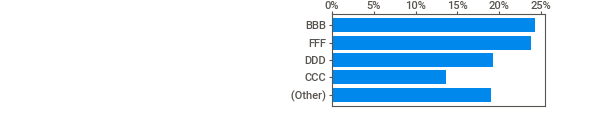
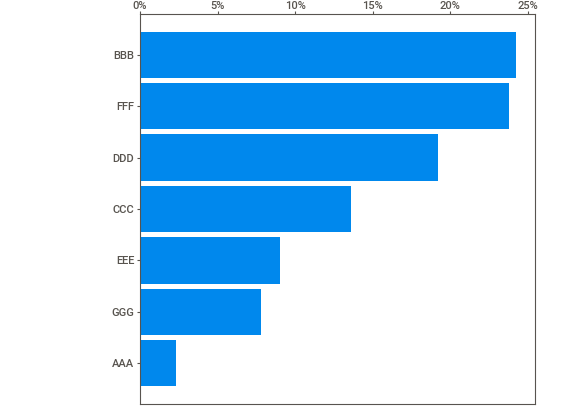
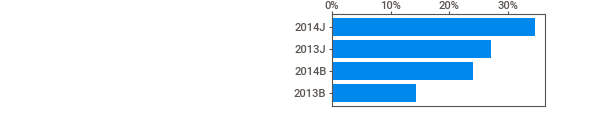
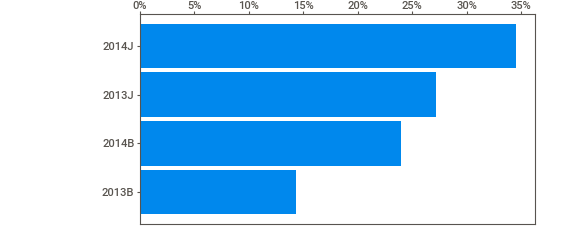
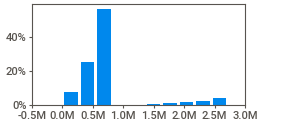
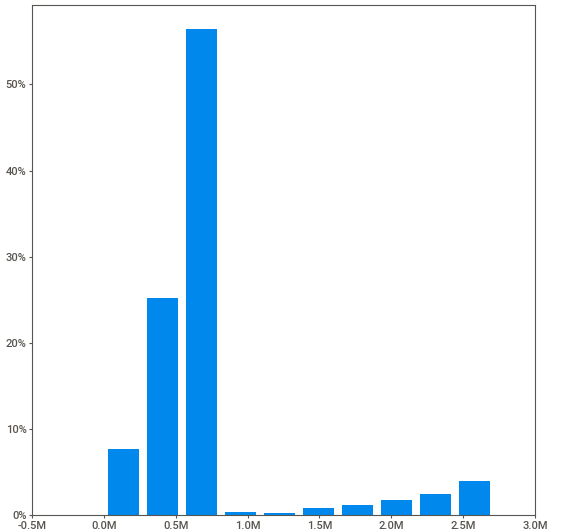
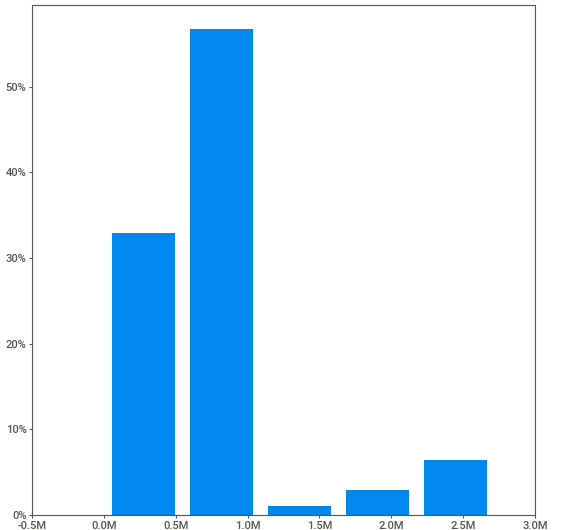
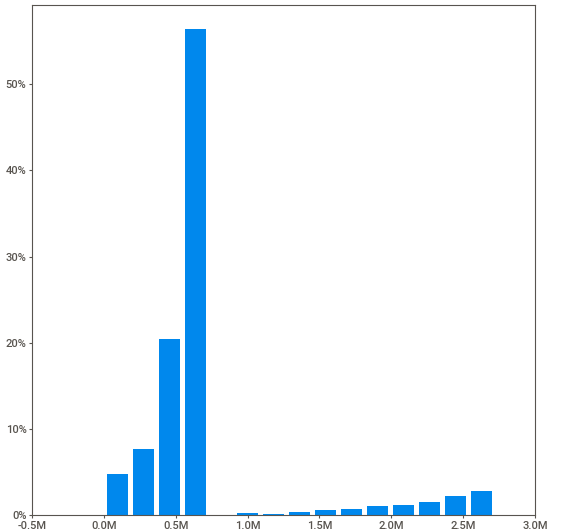
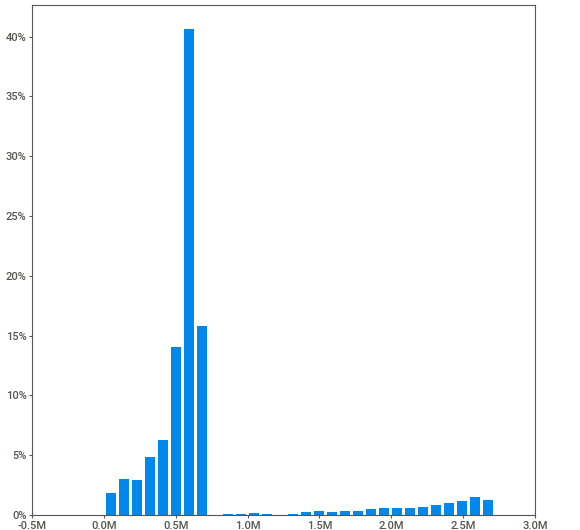
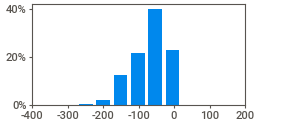
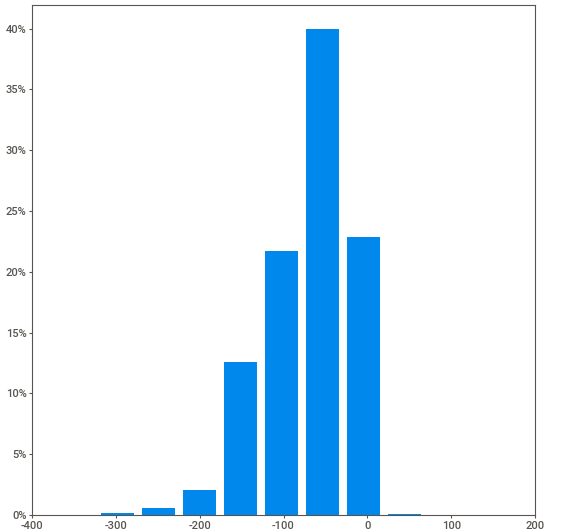
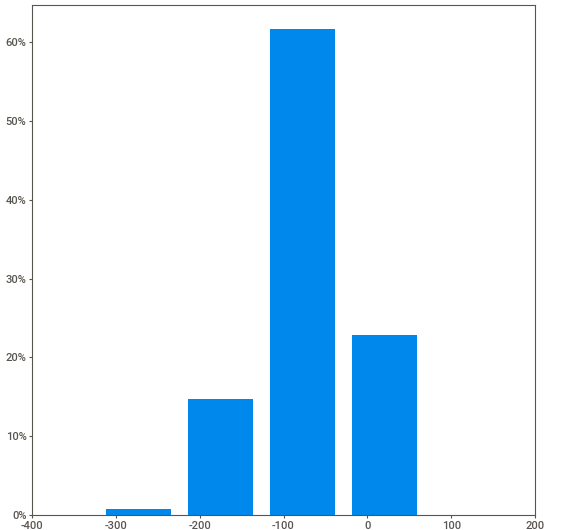
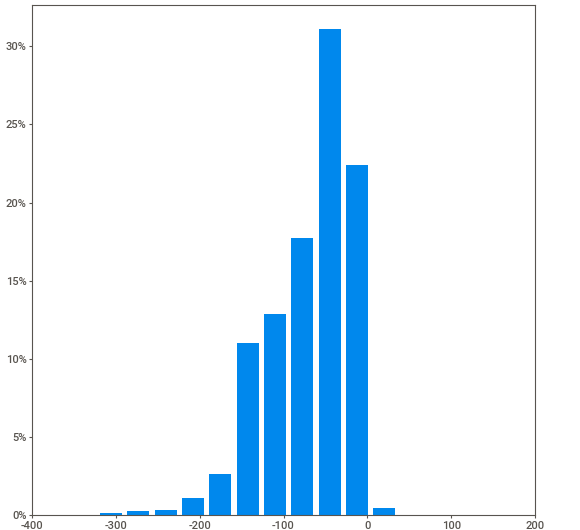
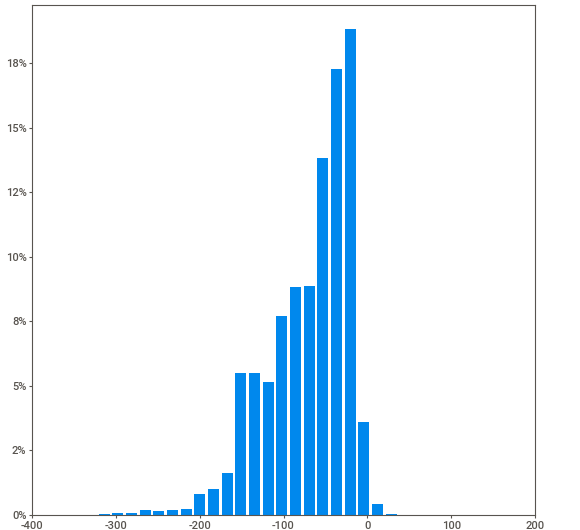
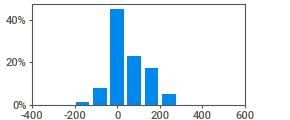
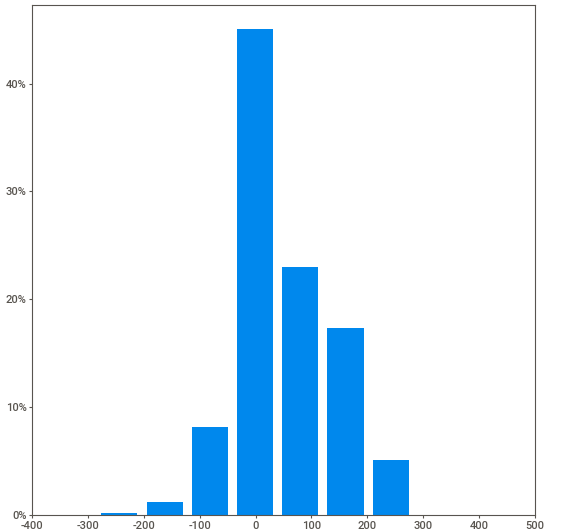
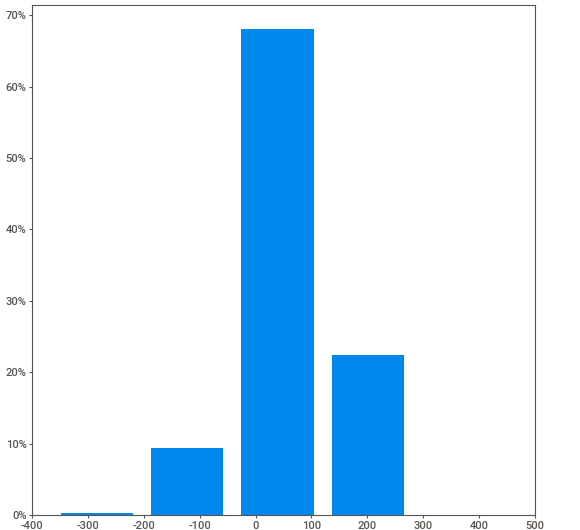
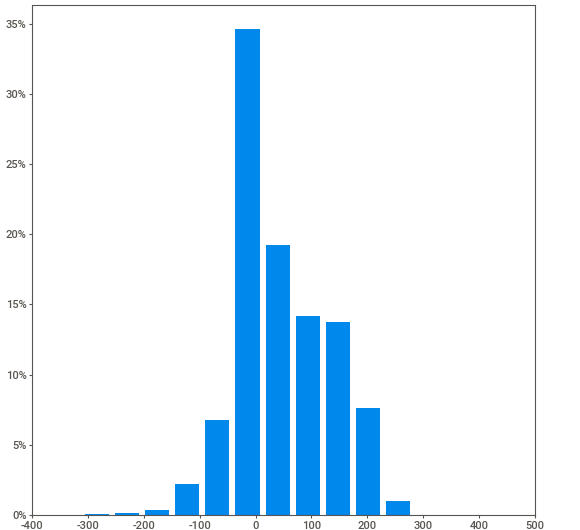
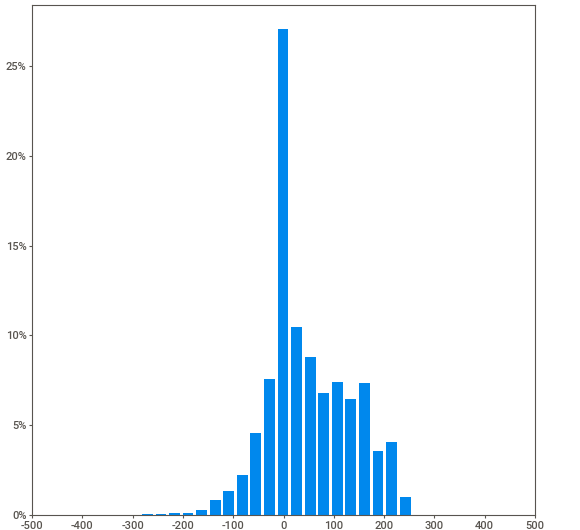
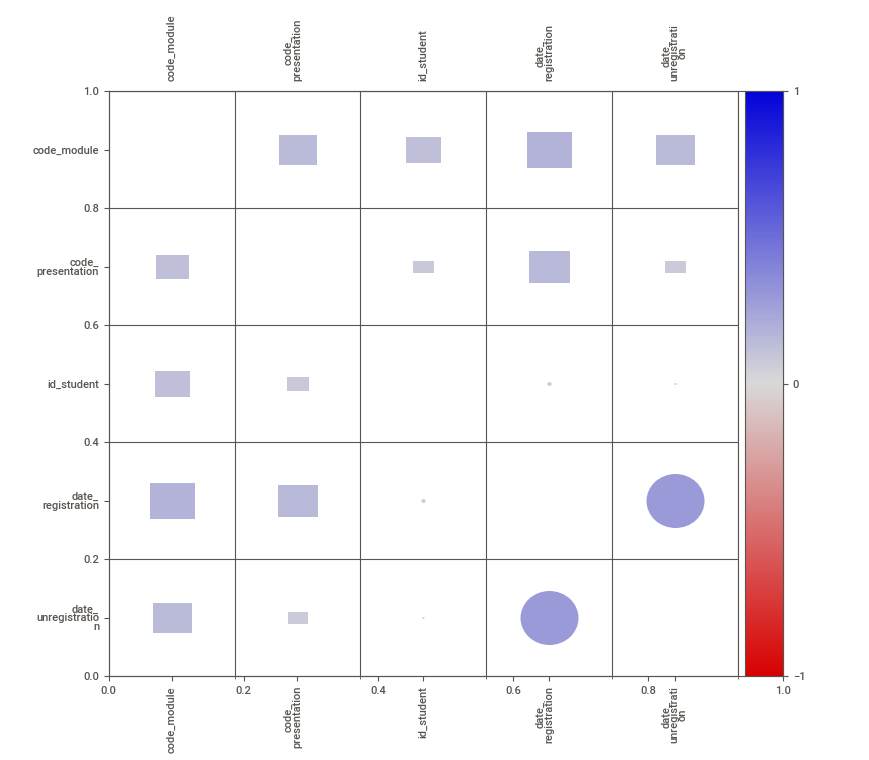
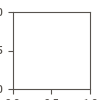

In [14]:
student_registration_report.show_notebook()

В целом, всё адекватно. Имеющиеся нули логичны, позже отфильтруем/отредактируем.  
Сюда вывел только для одного датафрейма для демонстрации.

# Далее
Нужно определиться, что мы понимаем под словом "курс".
Агрегируем данные для понимания. Логику агрегации поясняю в обоснавании.

In [23]:
assessments.groupby(['code_module', 'code_presentation'])\
            .agg({'assessment_type': 'sum'}).head()

assessment_type
code_module code_presentation                                       
AAA         2013J                                TMATMATMATMATMAExam
            2014J                                TMATMATMATMATMAExam
BBB         2013B              CMACMACMACMACMATMATMATMATMATMATMAExam
            2013J              CMACMACMACMACMATMATMATMATMATMATMAExam
            2014B              CMACMACMACMACMATMATMATMATMATMATMAExam

In [24]:
student_registration.groupby(['code_module', 'code_presentation'], as_index=False)\
                    .agg({'id_student': 'count'})\
                    .head()

,code_module,code_presentation,id_student
0,AAA,2013J,383
1,AAA,2014J,365
2,BBB,2013B,1767
3,BBB,2013J,2237
4,BBB,2014B,1613


__Курсом считается__ предмет проведенный в конкретный семестр. То есть, полным обозначением курса будет, например __"AAA 2013J"__.

### Обоснование:
1. Каждый из code_module + code_presentation имеет один экзамен по df assessments.
2. Каждый из code_module + code_presentation имеет продолжительность по df courses, что вполне логично для курса.
    
Была мысль, что может быть курс - это объединение по code_presentation или же по букве в code_presentation. И тогда курс состоял бы из нескольких предметов или длился несколько лет.
Но это нелогично по нексольким причинам:
1. Студент не может записываться на вторую половину курса без первой. Но при сортировке я вижу новых студентов ко второму году одного идентификатора (прим 2013j - 2014j)
2. Существует отдельная запись на предметы и в том случае, если бы курсом был именно code_presentation, id по предметам должны были совпадать.

# Пойдём по задачам

## 1. Сколько студентов успешно сдали только один курс? 
(Успешная сдача — зачёт по курсу на экзамене)

In [25]:
full_assessments_data = student_assessment.merge(assessments, how = 'inner', on = 'id_assessment')

In [26]:
full_assessments_data.query("assessment_type == 'Exam'")

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
52923,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0
52924,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0
52925,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0
52926,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0
52927,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0
...,...,...,...,...,...,...,...,...,...,...
95980,25368,652680,243,0,91.0,DDD,2014J,Exam,NaN,100.0
95981,25368,652732,249,0,47.0,DDD,2014J,Exam,NaN,100.0
95982,25368,652965,242,0,87.0,DDD,2014J,Exam,NaN,100.0
95983,25368,653051,242,0,27.0,DDD,2014J,Exam,NaN,100.0


In [27]:
full_assessments_data.query("assessment_type == 'Exam' & score >= 40")\
                     .groupby('id_student', as_index = False).agg({'assessment_type': 'count'})\
                     .query("assessment_type == 1").count()

id_student         3802
assessment_type    3802
dtype: int64

Успешно сдали только один курс 3706 студент. 

При условии, что данные по экзаменам есть только по предметам ССС и DDD, 
хотя данные df assessments предполагают наличие экзамена и в других предметах.
Отметим этот момент - нужно уточнение по данным.

##  2. Выявим самый сложный и самый простой экзамен.
Найти курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью.  
Завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

In [28]:
only_exams = full_assessments_data.query("assessment_type == 'Exam' & is_banked == 0")

In [29]:
only_exams.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
52923,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0
52924,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0
52925,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0
52926,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0
52927,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0


In [30]:
only_exams["is_success"] = only_exams.score >= 40

In [31]:
succes_ending_data = only_exams.groupby(['code_module','code_presentation','id_assessment'], as_index=False)\
            .agg({'is_success': 'sum', 'id_student': 'count'})\
            .rename(columns = {'id_student': 'all_attempts'})

In [32]:
succes_ending_data['completeness'] = succes_ending_data.is_success / succes_ending_data.all_attempts

In [33]:
succes_ending_data.sort_values('completeness')

,code_module,code_presentation,id_assessment,is_success,all_attempts,completeness
2,DDD,2013B,25340,504,602,0.837209
1,CCC,2014J,24299,1019,1168,0.872432
5,DDD,2014J,25368,842,950,0.886316
0,CCC,2014B,24290,664,747,0.888889
3,DDD,2013J,25354,878,968,0.907025
4,DDD,2014B,25361,485,524,0.925573


<Axes: xlabel='id_assessment', ylabel='completeness'>

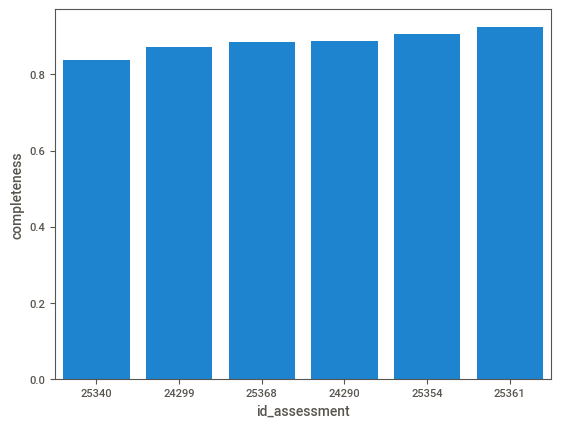

In [34]:
sns.barplot(data = succes_ending_data,
            x = 'id_assessment',
            y = 'completeness',
            order = succes_ending_data.sort_values('completeness').id_assessment)

## 3. По каждому предмету определим средний срок сдачи экзаменов.
Под сдачей понимаем последнее успешное прохождение экзамена студентом.

In [35]:
a = only_exams.query('is_success == True')\
            .sort_values(['id_student', 'id_assessment', 'date_submitted'])\
            .groupby(['id_student', 'id_assessment'], as_index = False).apply(lambda x: x.tail(1))

In [36]:
a.groupby('code_module', as_index = False).agg({'date_submitted' : 'mean'})

,code_module,date_submitted
0,CCC,239.345217
1,DDD,237.976006


## 4. Выявим самые популярные предметы (ТОП-3) по количеству регистраций на них. 
А также предметы с самым большим оттоком (ТОП-3)

In [21]:
student_registration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


<Axes: xlabel='code_module', ylabel='id_student'>

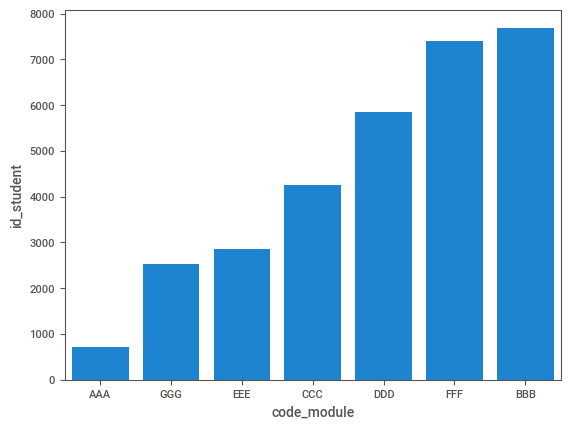

In [40]:
module_popularity = student_registration.groupby('code_module', as_index = False)\
                                        .agg({'id_student': 'nunique'})  #Здесь у нас имеются дубликаты, поэтому возьмем уникальные значения

sns.barplot(data = module_popularity,
            x = 'code_module',
            y = 'id_student',
            order = module_popularity.sort_values('id_student').code_module)

In [41]:
student_registration['unregistration'] = student_registration.date_unregistration.notna()

In [42]:
unreg_data = student_registration.groupby('code_module', as_index = False)\
                    .agg({'date_registration': 'count', 'unregistration': 'sum'})
unreg_data['churn_rate'] = unreg_data.unregistration / unreg_data.date_registration

<Axes: xlabel='code_module', ylabel='churn_rate'>

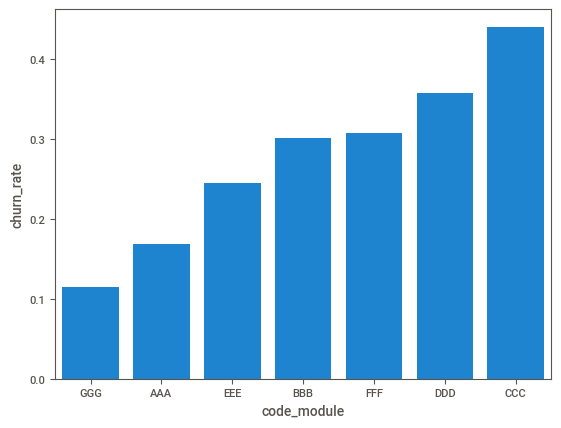

In [43]:
sns.barplot(data = unreg_data,
            x = 'code_module',
            y = 'churn_rate',
            order = unreg_data.sort_values('churn_rate').code_module)

Самые популярные предметы - BBB, FFF, DDD  
Предметы с наибольшим оттоком - ССС, DDD, FFF

## 5. В период с начала 2013 по конец 2014 выявим семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.

<Axes: xlabel='code_presentation', ylabel='completeness'>

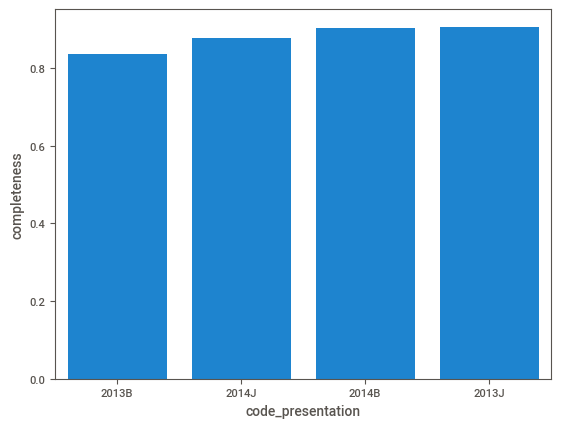

In [44]:
сourse_ending_data = only_exams.groupby(['code_presentation'], as_index=False)\
            .agg({'is_success': 'sum', 'id_student': 'count'})\
            .rename(columns = {'id_student': 'all_attempts'})
сourse_ending_data['completeness'] =  сourse_ending_data.is_success / сourse_ending_data.all_attempts

sns.barplot(data = сourse_ending_data,
            x = 'code_presentation',
            y = 'completeness',
            order = сourse_ending_data.sort_values('completeness').code_presentation)

In [45]:
сourse_ending_data

,code_presentation,is_success,all_attempts,completeness
0,2013B,504,602,0.837209
1,2013J,878,968,0.907025
2,2014B,1149,1271,0.904013
3,2014J,1861,2118,0.878659


<Axes: xlabel='code_presentation', ylabel='date_submitted'>

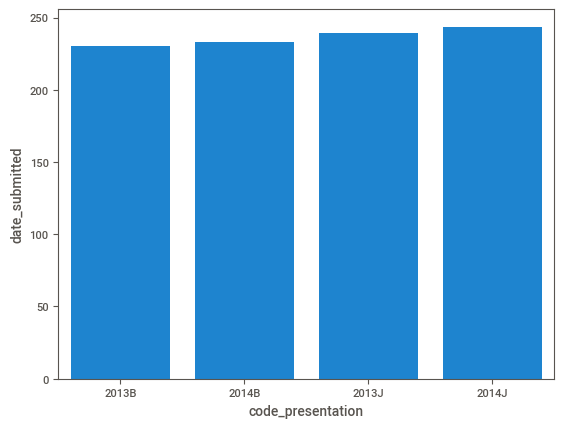

In [47]:
course_mean_submited = a.groupby('code_presentation', as_index = False).agg({'date_submitted': 'mean'})

sns.barplot(data = course_mean_submited,
            x = 'code_presentation',
            y = 'date_submitted',
            order = course_mean_submited.sort_values('date_submitted').code_presentation)

In [48]:
course_mean_submited

,code_presentation,date_submitted
0,2013B,230.164683
1,2013J,239.509112
2,2014B,232.997389
3,2014J,243.680279


Cеместр с самой низкой завершаемостью курсов - 2013B  
и самыми долгими средними сроками сдачи курсов - 2014J

## 6. Построим адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию.

R - среднее время сдачи одного экзамена студентом,  
F - завершаемость курсов студентом,  
M - среднее количество баллов, получаемое за экзамен студентом. 

In [55]:
comp_range = {0: 1, 1: 2, 2: 2, 4: 3}

In [21]:
def score_quantile(x): # функция для определения группы по оценкам
    if x <= quintiles[0.2]:
        return 1
    elif x <= quintiles[0.4]:
        return 2
    elif x <= quintiles[0.6]:
        return 3
    elif x <= quintiles[0.8]:
        return 4
    else:
        return 5 

In [20]:
def submitted_border(x): #функция для определения группы по времени сдачи экзамена
    if x <= 232:
        return 3
    elif x <= 240:
        return 2
    else:
        return 1

In [52]:
student_rfm = only_exams.groupby('id_student', as_index = False)\
                        .agg({'date_submitted': 'mean',
                                                 'is_success': 'sum',
                                                 'assessment_type': 'count',
                                                 'score': 'mean'})

student_rfm['completeness'] = student_rfm.is_success * student_rfm.assessment_type

student_rfm.rename(columns = {'date_submitted': 'mean_submitted_time',
                              'score': 'mean_score'}, inplace = True)
student_rfm = student_rfm[['id_student', 'mean_submitted_time', 'completeness', 'mean_score']]

In [53]:
quintiles = student_rfm.mean_score.quantile([.2, .4, .6, .8]).to_dict()

In [56]:
student_rfm['r'] = student_rfm.mean_submitted_time.apply(lambda x: submitted_border(x))
student_rfm['f'] = student_rfm.completeness.apply(lambda x: comp_range[x])
student_rfm['m'] = student_rfm.mean_score.apply(lambda x: score_quantile(x))
student_rfm['rfm_score'] = student_rfm['r'].map(str) + student_rfm['f'].map(str) + student_rfm['m'].map(str)

In [57]:
segt_map = {
    r'[3][3]': 'Лучшие среди лучших',
    r'[1-2][3]': 'Лучшие',
    r'[3][2]': 'Попытка в успех',
    r'[1-2][2]': 'Средний класс',
    r'[1-3][1]': 'Обреченные'
}

In [58]:
student_rfm['segment'] = student_rfm['r'].map(str) + student_rfm['f'].map(str)
student_rfm['segment'] = student_rfm['segment'].replace(segt_map, regex=True)

__r__ - смотря на распределение, решил разделить на три группы по 'верхушкам распределения', 
соответственно до 232, от 232 до 240 и от 240

__f__ - изначально при расчете завершаемости курсов не использовал данный в задаче подсчёт завершаемости, 
так как 1 из 1 пройденных курсов не равняется 2 из 2 и т.д., использовал вариант с градацией,
потом при создании столбца f немого изменил значение для удобоваримости.

__m__ - относительно симметричное ровное распределение, поэтому просто раскидал по квантилям.

Далее построил рамки для кластеров исходя из своего понимание того, как должны делиться ученики:
    
    Лучшие среди лучших- Закончили быстро оба курса
    Лучшие - Закончили не быстро оба курса 
    Попытка в успех - Закончили быстро один курс из двух
                      Закончили быстро один курс 
    Средний класс - Закончили не быстро один курс из двух 
                    Закончили средне один курс 
    Упорные - Закончили медленно один курс 
    Обреченные - Не закончили ни один курс
    
__UPD.__ Исходя из предыдущих мыслей построил обзорный дашборд, и понял, что группа 3 по f слишком мала, и отдельно ее рассматривать не имеет смысла, поэтому переопределил значения в группу выше. Как итог остались следующие группы:
    Лучшие среди лучших
    Лучшие
    Попытка в успех
    Средний класс
    Обреченные

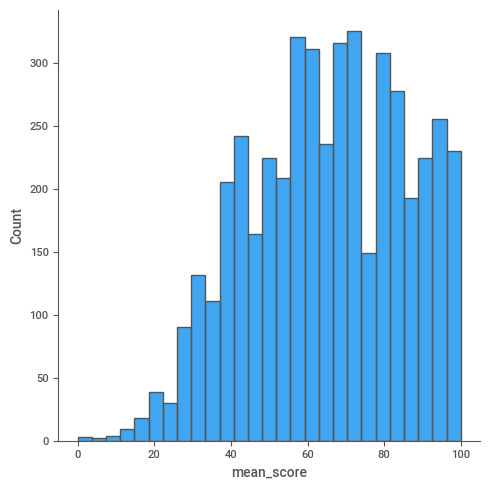

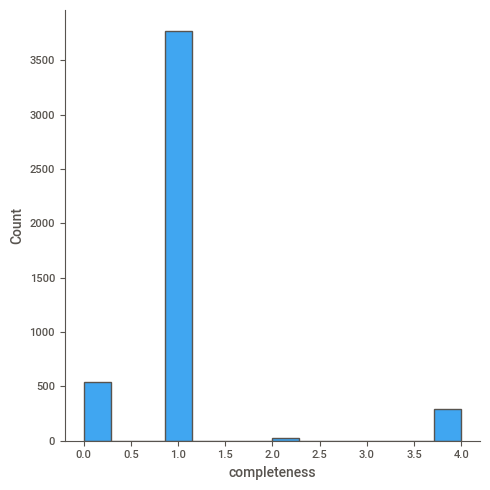

In [59]:
sns.displot(student_rfm.mean_score)
sns.displot(student_rfm.completeness)

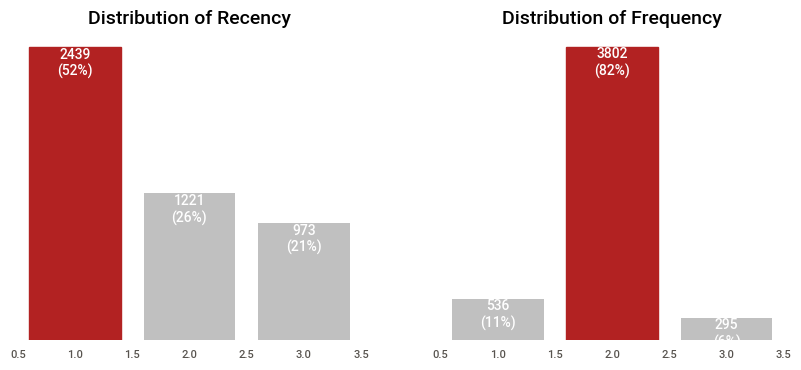

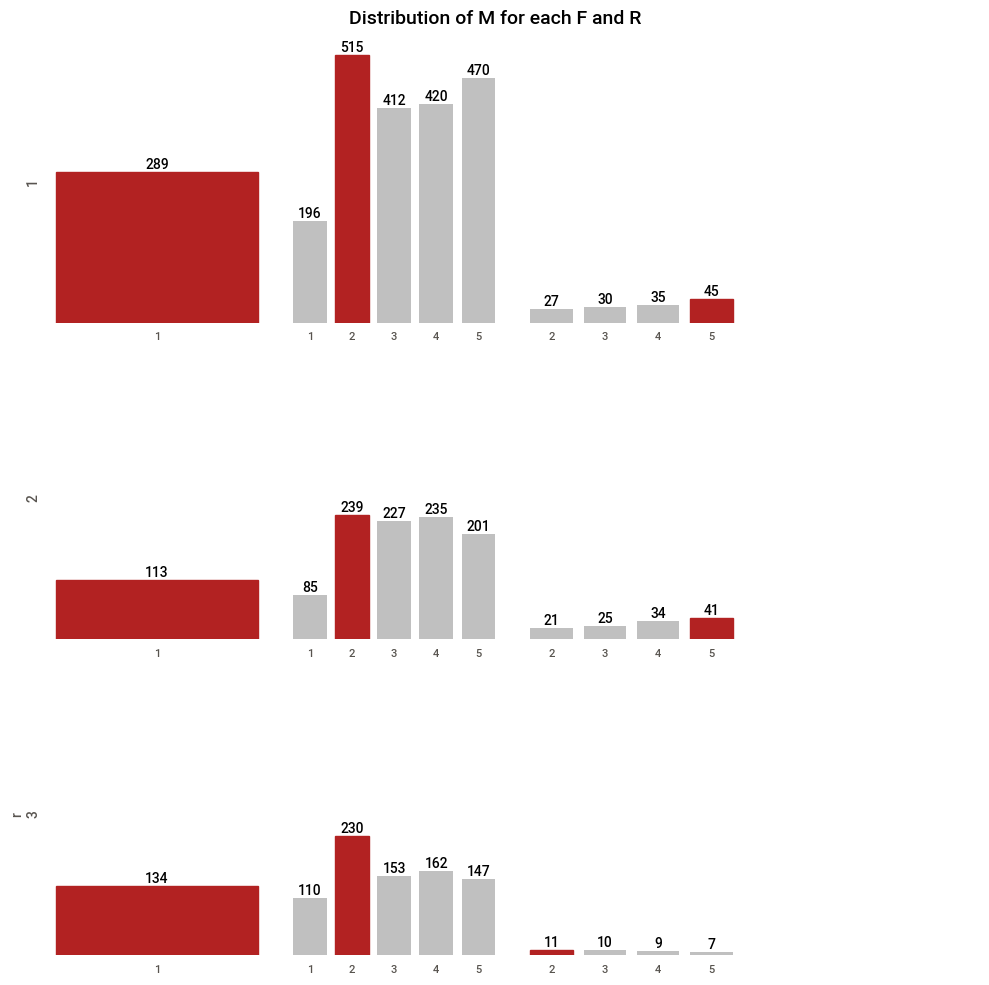

In [61]:
# График распределения клиентов по R и F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['r', 'f']):
    parameters = {'r': 'Recency', 'f': 'Frequency'}
    y = student_rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# График для распределения M для RF
fig, axes = plt.subplots(nrows=3, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 4)
f_range = range(1, 5)
for r in r_range:
    for f in f_range:
        y = student_rfm[(student_rfm['r'] == r) & (student_rfm['f'] == f)]['m'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nf'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('r\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()